# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Описание данных:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак: 
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

import statistics as st
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [2]:
try: df = pd.read_csv('/Users/dmitry/Desktop/yandex_python/10. Численные методы/autos.csv')
except: df = pd.read_csv('/datasets/autos.csv')

display (df.head())
df.info()
len_in1 = len(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

/Users/dmitry/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

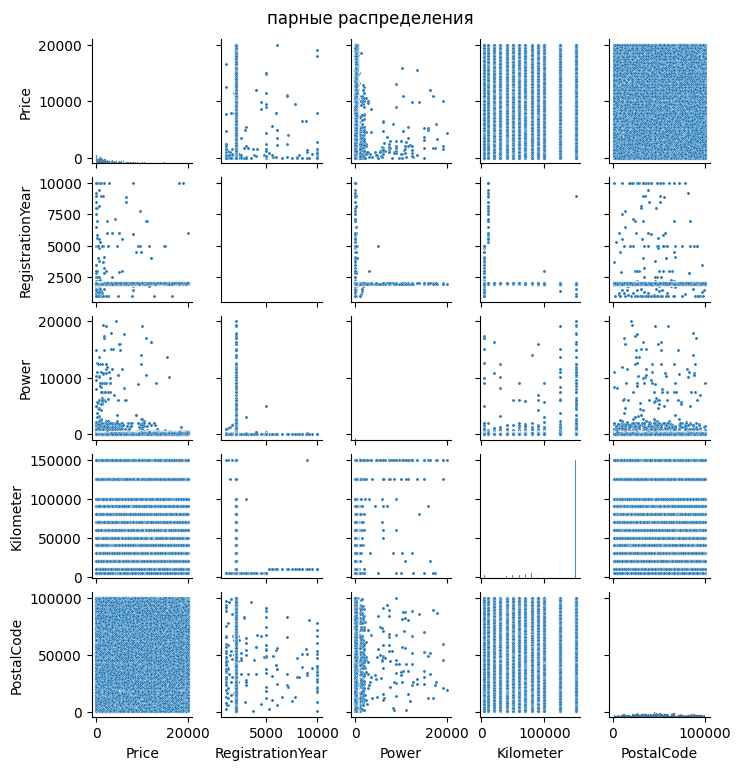

In [4]:
df_pair_dist = df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'PostalCode']]

plt.figure()
dist = sns.pairplot(df_pair_dist, plot_kws = dict(alpha = 1, s = 5), height = 1.5)
dist.fig.suptitle(f'парные распределения', y=1.02)
plt.show()

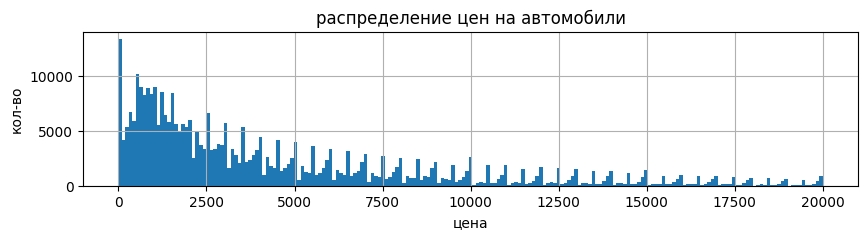

In [5]:
plt.figure(figsize = (10,2))
plt.hist(df['Price'], bins = 201)

plt.title('распределение цен на автомобили')
plt.xlabel('цена')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

In [6]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [7]:
df['NumberOfPictures'].unique()

array([0])

#### Промедуточные выводы:

Некоторыне параметры не могут влиять на стоимость автомобиля:
   - DateCrawled
   - RegistrationMonth
   - LastSeen
   - PostalCode

В загруженных данных наблюдаются аномальные значения в категориях:
   - Registration year
   - Power
   
Набор данных содержит пропуски в категориях:
   - ~ 11% VehicleType
   - ~ 6%  Gearbox
   - ~ 6%  Model
   - ~ 9%  FuelType
   - ~ 20% Repaired

Дублирующие значения в категории:
   - FuelType
   
Полностью отсутствуют значения в категории:
   - NumberOfPictures

### Предобработка данных

#### Удалим параметры не влияющие на стоимость автомобиля

In [8]:
try:
    df2 = df.drop(['DateCrawled', 'LastSeen', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'], axis =1)
except:
    df2=df

#### Удалим данные с нулевой ценой

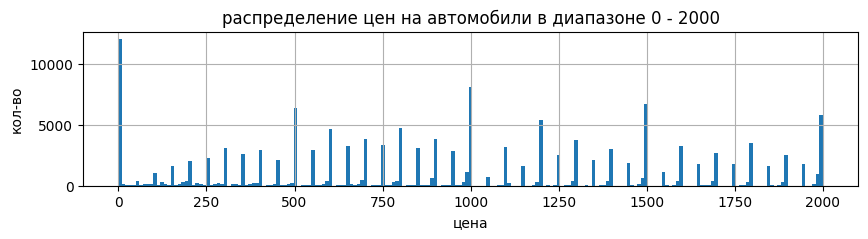

In [9]:
plt.figure(figsize=(10,2))
df2['Price'].hist(bins = 201, range = (0,2000))

plt.title('распределение цен на автомобили в диапазоне 0 - 2000')
plt.xlabel('цена')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

In [10]:
len_in = len(df2)
df2 = df2.loc[df2['Price'] > 200]
len_fin = len(df2)
print('выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

выборка сократилась на 5.5 %


#### Удалим аномалии в Registration year

т.к. год регистрации автомобиля не может быть больше года создания анкеты, то удалим эти данные

In [11]:
pd.DatetimeIndex(df['DateCreated']).year.unique()

Index([2016, 2015, 2014], dtype='int32', name='DateCreated')

In [12]:
df2['DateCreated'] = pd.to_datetime(df2['DateCreated'])
df2['year_created'] = pd.DatetimeIndex(df2['DateCreated']).year


len_in = len(df2)
df2 = df2.loc[df2['RegistrationYear'] < df2['year_created']]
len_fin = len(df2)
print('выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

выборка сократилась на 6.5 %


удалим данные по старым автомобилям:

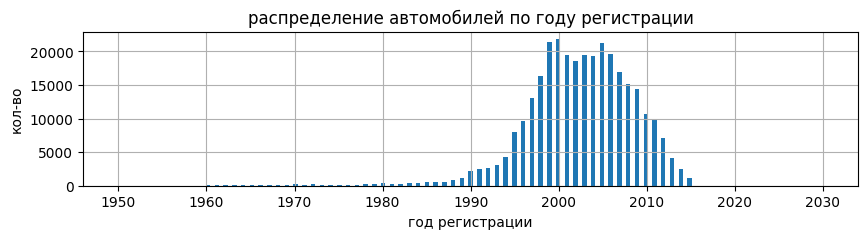

In [13]:
plt.figure(figsize = (10,2))
df2['RegistrationYear'].hist(bins = 161, range = (1950, 2030))

plt.title('распределение автомобилей по году регистрации')
plt.xlabel('год регистрации')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

In [14]:
len_in = len(df2)

df2 = df2.loc[df2['RegistrationYear'] > 1980]

len_fin = len(df2)
print('выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

выборка сократилась на 1.1 %


#### Удалим аномалии в Power 

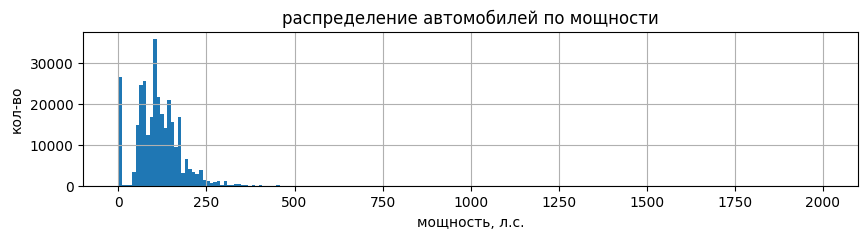

In [15]:
plt.figure(figsize = (10,2))
df2['Power'].hist(bins = 201, range = (0, 2000))

plt.title('распределение автомобилей по мощности')
plt.xlabel('мощность, л.с.')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

In [16]:
len_in = len(df2)

df2 = df2.loc[df2['Power'] < 1000]

len_fin = len(df2)
print('суммарно выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

суммарно выборка сократилась на 0.1 %


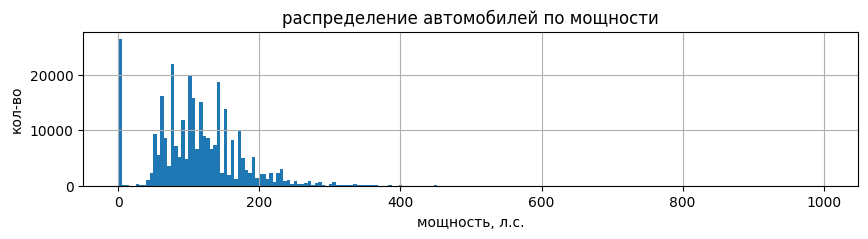

In [17]:
plt.figure(figsize = (10,2))
df2['Power'].hist(bins = 201)

plt.title('распределение автомобилей по мощности')
plt.xlabel('мощность, л.с.')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

заменим нулевые значения power на моду по соответствующей модели, оставшиеся нулевые значения удалим

In [18]:
pt = df2.pivot_table(index = ['Model'], values = 'Power', aggfunc = st.mode)
#display(pt)

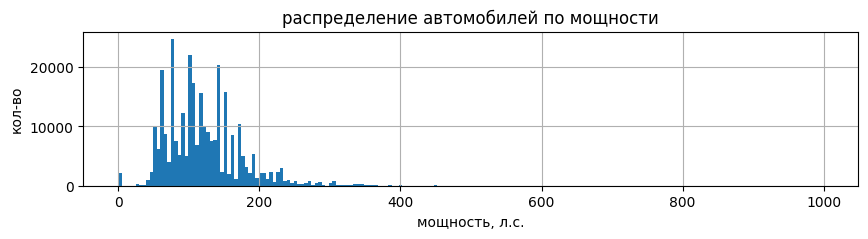

In [19]:
df2 = df2.merge(pt, on='Model', how='left')
try:
    df2.loc[df2['Power_x'] < 25, 'Power_x'] = df2['Power_y']
    df2 = df2.drop('Power_y', axis =1)
except: df2 = df2
    
df2 = df2.rename(columns = {'Power_x': 'Power'})

plt.figure(figsize = (10,2))
df2['Power'].hist(bins = 201)

plt.title('распределение автомобилей по мощности')
plt.xlabel('мощность, л.с.')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

In [20]:
len_in = len(df2)
df2 = df2.loc[df2['Power'] > 25]
len_fin = len(df2)
print('выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

выборка сократилась на 1.8 %


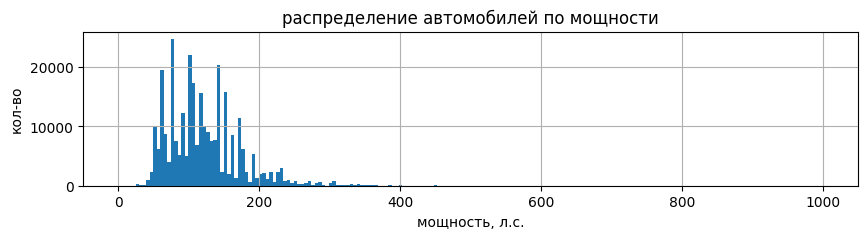

In [21]:
plt.figure(figsize = (10,2))
df2['Power'].hist(bins = 201, range = (0,1000))

plt.title('распределение автомобилей по мощности')
plt.xlabel('мощность, л.с.')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

#### Заполнение пропусков Repaired

отсутствие данных о ремонте на 'no'

In [22]:
print('Repaired = no: \t', df2.loc[df2['Repaired'] == 'no']['Repaired'].count())
print('Repaired = yes: \t', df2.loc[df2['Repaired'] == 'yes']['Repaired'].count())
print('\nmode:\t', df2['Repaired'].mode())

Repaired = no: 	 227690
Repaired = yes: 	 28309

mode:	 0    no
Name: Repaired, dtype: object


In [23]:
df2['Repaired'] = df2['Repaired'].fillna('no')

#### Заполнение пропусков FuelType

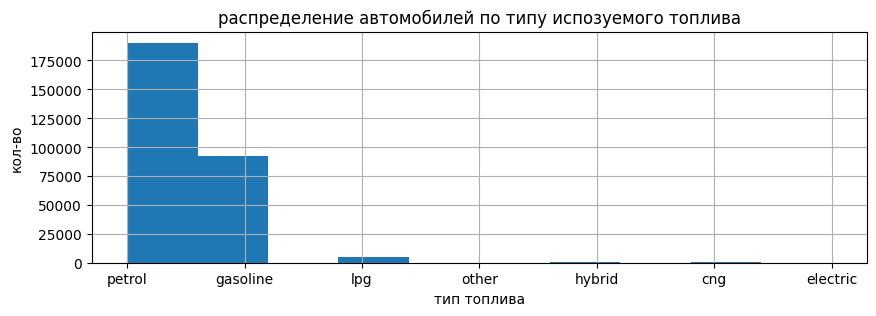

In [24]:
plt.figure(figsize = (10,3))
df2['FuelType'].hist()

plt.title('распределение автомобилей по типу испозуемого топлива')
plt.xlabel('тип топлива')
plt.ylabel('кол-во')
plt.grid(True)
plt.show()

petrol и gasoline - одно и тоже, поэтому заменим их

In [25]:
df2.loc[df2['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

print('доля бензиновых двигателей составляет:',
      round(100*len(df2.loc[df2['FuelType'] == 'petrol']) / len(df2.loc[df2['FuelType'].isna() == False]),2),
      '%')

доля бензиновых двигателей составляет: 98.04 %


подавляющее большинство машин являются бензиновыми, поэтому пропуски 'FuelType' заполним 'petrol'

In [26]:
df2['FuelType'] = df2['FuelType'].fillna('petrol')

#### Заполнение пропусков VehicleType, Gearbox, Model

пропуски в 'VehicleType', 'Gearbox', 'Model' заполним значением other

In [27]:
df2['VehicleType'] = df2['VehicleType'].fillna('other')
df2['Gearbox'] = df2['Gearbox'].fillna('other')
df2['Model'] = df2['Model'].fillna('other')

#### удалим столбцы DateCreated и year_created

In [28]:
try: df2 = df2.drop(['DateCreated', 'year_created'], axis =1)
except: df2= df2
    
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303852 entries, 0 to 309305
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             303852 non-null  int64  
 1   VehicleType       303852 non-null  object 
 2   RegistrationYear  303852 non-null  int64  
 3   Gearbox           303852 non-null  object 
 4   Power             303852 non-null  float64
 5   Model             303852 non-null  object 
 6   Kilometer         303852 non-null  int64  
 7   FuelType          303852 non-null  object 
 8   Brand             303852 non-null  object 
 9   Repaired          303852 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 25.5+ MB


#### удаляем дубликаты

In [29]:
print('обнаружено дубликатов:\t', df2.duplicated().sum())

len_in = len(df2)
df2 = df2.drop_duplicates(keep = 'first')
len_fin = len(df2)
print('выборка сократилась на', round(100 - 100*len_fin/len_in, 1), '%')

print('осталось дубликатов:\t', df2.duplicated().sum())

обнаружено дубликатов:	 52646
выборка сократилась на 17.3 %
осталось дубликатов:	 0


#### смотрим общее сокращение выборки после всех манипуляций

In [30]:
df2.isna().sum()

len_fin = len(df2)
print('суммарно выборка сократилась на', round(100 - 100*len_fin/len_in1, 1), '%')

суммарно выборка сократилась на 29.1 %


### Промедуточные выводы:

В результате предобработки данные выполнено:

    Удалены параметры, не влияющие на cтоимость автомобиля
       - DateCrawled
       - RegistrationMonth
       - LastSeen
       - PostalCode
       - NumberOfPictures

    удалены аномальные значения в категориях:
       - price - нулевые значения удалены
       - Registration year - ограничен значениями 1980 - 2016
       - Power - нулевые значения заменены модой по соответствующей моделе
   
    Заполнены пропуски в категориях:
       - ~ 11% VehicleType - заменено на 'other'
       - ~ 6%  Gearbox - заменено на 'other'
       - ~ 6%  Model - заменено на 'other'
       - ~ 9%  FuelType - заменено на 'petrol'
       - ~ 20% Repaired - заменено на 'no'
    
    Удалены дубликаты (~17% выборки)

Общее сокращение выборки составило 29.1%

## Обучение моделей

### Разделение данных на тестовую и обучающую выборки. масштабирование, категоривазация

In [31]:
# разделение выборок
features = df2.drop('Price', axis = 1)
target = df2['Price']
(f_train, f_valid, t_train, t_valid) = train_test_split(features, target, test_size = 0.2, random_state = 12345)
(f_train, f_test, t_train, t_test) = train_test_split(f_train, t_train, test_size = 0.25, random_state = 12345)

print('f_train:', f_train.shape)
print('f_train:', t_train.shape)

print('f_train:', f_valid.shape)
print('f_train:', t_valid.shape)

print('f_train:', f_test.shape)
print('f_train:', t_test.shape)

f_train: (150723, 9)
f_train: (150723,)
f_train: (50242, 9)
f_train: (50242,)
f_train: (50241, 9)
f_train: (50241,)


In [32]:
cat_features = ['VehicleType', 'FuelType', 'Gearbox', 'Brand', 'Model', 'Repaired']

ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown = 'ignore')

#обучаем и форматируем тренировочную выборку
data = ohe_encoder.fit_transform(f_train[cat_features])
columns = ohe_encoder.get_feature_names_out()

f_train_temp = pd.DataFrame(data = data, columns = columns, index = f_train.index)
f_train = f_train.merge(f_train_temp, on = f_train.index, how = 'left')
f_train = f_train.set_index('key_0')
f_train.drop(cat_features, axis=1, inplace=True)


/Users/dmitry/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
#форматируем валидационную
data = ohe_encoder.transform(f_valid[cat_features]) # обученный энкодер применили к тест. выборке
f_valid_temp = pd.DataFrame(data = data, columns = columns, index = f_valid.index)
f_valid = f_valid.merge(f_valid_temp, on = f_valid.index, how = 'left') # объединили датафреймы
f_valid = f_valid.set_index('key_0') # установили индекс
f_valid.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

#форматируем тестовую выборки
data = ohe_encoder.transform(f_test[cat_features]) # обученный энкодер применили к тест. выборке
f_test_temp = pd.DataFrame(data = data, columns = columns, index = f_test.index)
f_test = f_test.merge(f_test_temp, on = f_test.index, how = 'left') # объединили датафреймы
f_test = f_test.set_index('key_0') # установили индекс
f_test.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

/Users/dmitry/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dmitry/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
print('f_train:', f_train.shape)
print('f_train:', t_train.shape)

print('f_train:', f_valid.shape)
print('f_train:', t_valid.shape)

print('f_train:', f_test.shape)
print('f_train:', t_test.shape)

f_train: (150723, 302)
f_train: (150723,)
f_train: (50242, 302)
f_train: (50242,)
f_train: (50241, 302)
f_train: (50241,)


In [35]:
display (f_train.head())

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Repaired_yes
key_0,,,,,,,,,,,,,,,,,,,,,
289534,2007,116.0,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200315,1993,60.0,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154363,2002,50.0,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84432,2000,116.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87051,2002,60.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#масштабирование
col = list(f_train)

scaler = StandardScaler()
scaler.fit(f_train[col])

f_train[col] = scaler.transform(f_train[col])
f_valid[col] = scaler.transform(f_valid[col])
f_test[col]  = scaler.transform(f_test[col])

In [37]:
display(f_train.head())

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Repaired_yes
key_0,,,,,,,,,,,,,,,,,,,,,
289534,0.726347,-0.123089,0.611870,-0.264971,-0.231361,-0.192803,1.607997,-0.544976,-0.203295,-0.508419,...,-0.073094,-0.02727,-0.024443,-0.027633,-0.059235,-0.024848,-0.024032,-0.04927,-0.092512,-0.339743
200315,-1.732875,-1.149169,-0.055078,-0.264971,-0.231361,-0.192803,-0.621892,1.834942,-0.203295,-0.508419,...,-0.073094,-0.02727,-0.024443,-0.027633,-0.059235,-0.024848,-0.024032,-0.04927,-0.092512,-0.339743
154363,-0.151947,-1.332398,-0.055078,-0.264971,-0.231361,-0.192803,-0.621892,1.834942,-0.203295,-0.508419,...,-0.073094,-0.02727,-0.024443,-0.027633,-0.059235,-0.024848,-0.024032,-0.04927,-0.092512,-0.339743
84432,-0.503264,-0.123089,0.611870,-0.264971,-0.231361,-0.192803,-0.621892,-0.544976,-0.203295,1.966883,...,-0.073094,-0.02727,-0.024443,-0.027633,-0.059235,-0.024848,-0.024032,-0.04927,-0.092512,-0.339743
87051,-0.151947,-1.149169,0.611870,-0.264971,-0.231361,-0.192803,-0.621892,1.834942,-0.203295,-0.508419,...,-0.073094,-0.02727,-0.024443,-0.027633,-0.059235,-0.024848,-0.024032,-0.04927,-0.092512,-0.339743


In [38]:
def plot_rmse (rmse_t, rmse_v,x, model, x_label):
    plt.figure(figsize = (10,2))
    plt.plot(x,rmse_t, '-o')
    plt.plot(x, rmse_v, '-o')
    plt.title(f'RMSE for {model}')
    plt.xlabel(x_label)
    plt.ylabel('RMSE')
    plt.legend(['rmse_train', 'rmse_valid'])
    plt.grid(True)
    plt.show()

### Модель: линейная регрессия

In [39]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(f_train, t_train)
rmse_t = mean_squared_error(t_train, model_lin_reg.predict(f_train))**0.5
rmse_v = mean_squared_error(t_valid, model_lin_reg.predict(f_valid))**0.5
print('RMSE train =', round(rmse_t,0), '\tRMSE valid =', round(rmse_v,0))

RMSE train = 2440.0 	RMSE valid = 2420.0


### Модель: дерево решений

In [40]:
rmse_t = []
rmse_v = []
x = []

for depth in range(5, 51, 5):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(f_train, t_train)
    res_t = mean_squared_error(t_train, model.predict(f_train))**0.5
    res_v = mean_squared_error(t_valid, model.predict(f_valid))**0.5
    
    rmse_t.append(res_t)
    rmse_v.append(res_v)
    x.append(depth)
    
    print('depth = ', depth, '\tRMSE train =', round(res_t,0), '\tRMSE valid =', round(res_v,0))

depth =  5 	RMSE train = 2341.0 	RMSE valid = 2337.0
depth =  10 	RMSE train = 1884.0 	RMSE valid = 1965.0
depth =  15 	RMSE train = 1488.0 	RMSE valid = 1871.0
depth =  20 	RMSE train = 1198.0 	RMSE valid = 1891.0
depth =  25 	RMSE train = 1032.0 	RMSE valid = 1919.0
depth =  30 	RMSE train = 945.0 	RMSE valid = 1928.0
depth =  35 	RMSE train = 906.0 	RMSE valid = 1943.0
depth =  40 	RMSE train = 890.0 	RMSE valid = 1957.0
depth =  45 	RMSE train = 884.0 	RMSE valid = 1951.0
depth =  50 	RMSE train = 883.0 	RMSE valid = 1949.0


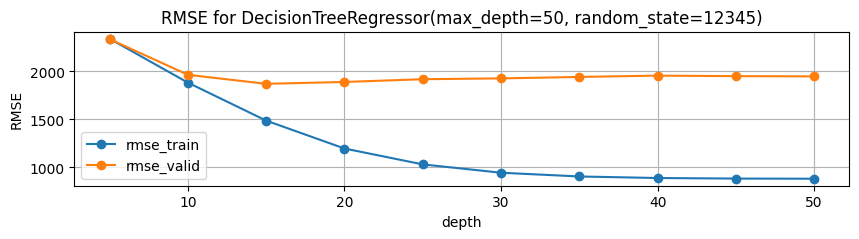

In [41]:
plot_rmse (rmse_t, rmse_v,x, model, 'depth')

определим лучшую модель decision tree

In [42]:
best_tree = DecisionTreeRegressor(random_state=12345, max_depth = 20)

### Модель: случайный лес

In [43]:
rmse_t = []
rmse_v = []
x = []

for n_est in [3,10,20,35,50]:
    model = RandomForestRegressor(random_state=12345, max_depth = 15, n_estimators = n_est, n_jobs = 6)
    model.fit(f_train, t_train)
    res_t = mean_squared_error(t_train, model.predict(f_train))**0.5
    res_v = mean_squared_error(t_valid, model.predict(f_valid))**0.5
    
    rmse_t.append(res_t)
    rmse_v.append(res_v)
    x.append(n_est)
    
    print('n_est = ', n_est, '\tRMSE train =', round(res_t,0), '\tRMSE valid =', round(res_v,0))

n_est =  3 	RMSE train = 1506.0 	RMSE valid = 1779.0
n_est =  10 	RMSE train = 1443.0 	RMSE valid = 1715.0
n_est =  20 	RMSE train = 1434.0 	RMSE valid = 1703.0
n_est =  35 	RMSE train = 1425.0 	RMSE valid = 1694.0
n_est =  50 	RMSE train = 1423.0 	RMSE valid = 1691.0


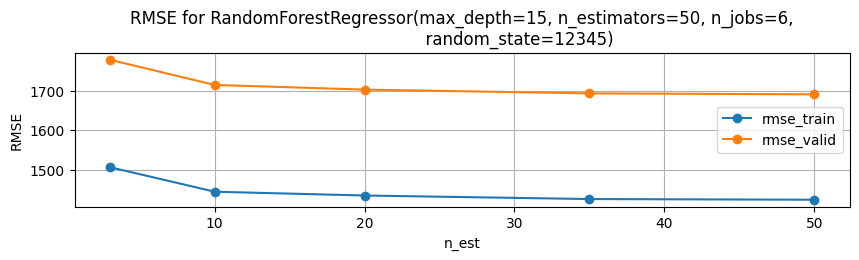

In [44]:
plot_rmse (rmse_t, rmse_v,x, model, 'n_est')

определим лучшую модель random forest

In [45]:
best_random_forest = RandomForestRegressor(random_state=12345, max_depth = 15, n_estimators = 20)

### Модель: LightGBM

т.к. lightgbm работает в т.ч. с категориальными данными, по подготовим данные

In [46]:
features_lgb = df2.drop('Price', axis = 1)
display(features_lgb)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,other,1993,manual,75.0,golf,150000,petrol,volkswagen,no
1,coupe,2011,manual,190.0,other,125000,petrol,audi,yes
2,suv,2004,auto,163.0,grand,125000,petrol,jeep,no
3,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69.0,fabia,90000,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...
309296,wagon,2004,manual,55.0,fabia,150000,petrol,skoda,no
309300,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
309303,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
309304,bus,1996,manual,102.0,transporter,150000,petrol,volkswagen,no


In [47]:
# разделение выборок
features_lgb = df2.drop('Price', axis = 1)
target_lgb = df2['Price']

col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
features_lgb[col] = features_lgb[col].astype('category')

(f_train_lgb, f_valid_lgb, t_train_lgb, t_valid_lgb) = train_test_split(features_lgb,
                                                                        target_lgb,
                                                                        test_size = 0.2,
                                                                        random_state = 12345)
(f_train_lgb, f_test_lgb, t_train_lgb, t_test_lgb) = train_test_split(f_train_lgb,
                                                                      t_train_lgb,
                                                                      test_size = 0.25,
                                                                      random_state = 12345)

print('f_train_lgb:', f_train_lgb.shape)
print('t_train_lgb:', t_train_lgb.shape)

print('f_valid_lgb:', f_valid_lgb.shape)
print('t_valid_lgb:', t_valid_lgb.shape)

print('f_test_lgb:', f_test_lgb.shape)
print('t_test_lgb:', t_test_lgb.shape, '\n')

f_train_lgb.info()

f_train_lgb: (150723, 9)
t_train_lgb: (150723,)
f_valid_lgb: (50242, 9)
t_valid_lgb: (50242,)
f_test_lgb: (50241, 9)
t_test_lgb: (50241,) 

<class 'pandas.core.frame.DataFrame'>
Index: 150723 entries, 289534 to 174449
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       150723 non-null  category
 1   RegistrationYear  150723 non-null  int64   
 2   Gearbox           150723 non-null  category
 3   Power             150723 non-null  float64 
 4   Model             150723 non-null  category
 5   Kilometer         150723 non-null  int64   
 6   FuelType          150723 non-null  category
 7   Brand             150723 non-null  category
 8   Repaired          150723 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 5.6 MB


In [48]:
rmse_t = []
rmse_v = []
x = []

for learning_rate in np.arange(0.1, 2, 0.1):
    model = lgb.LGBMRegressor(random_state=12345,
                              n_jobs = 6,
                              n_estimators = 100,
                              max_depth = 15,
                              num_leaves =50,
                              learning_rate = learning_rate)
    
    model.fit(f_train_lgb, t_train_lgb)
    res_t = mean_squared_error(t_train_lgb, model.predict(f_train_lgb))**0.5
    res_v = mean_squared_error(t_valid_lgb, model.predict(f_valid_lgb))**0.5
    
    rmse_t.append(res_t)
    rmse_v.append(res_v)
    x.append(learning_rate)
    
    print('learning_rate = ', round(learning_rate,1), '\tRMSE train =', round(res_t,0),
          '\tRMSE valid =', round(res_v,0))

learning_rate =  0.1 	RMSE train = 1522.0 	RMSE valid = 1584.0
learning_rate =  0.2 	RMSE train = 1469.0 	RMSE valid = 1571.0
learning_rate =  0.3 	RMSE train = 1449.0 	RMSE valid = 1583.0
learning_rate =  0.4 	RMSE train = 1436.0 	RMSE valid = 1591.0
learning_rate =  0.5 	RMSE train = 1421.0 	RMSE valid = 1598.0
learning_rate =  0.6 	RMSE train = 1414.0 	RMSE valid = 1613.0
learning_rate =  0.7 	RMSE train = 1408.0 	RMSE valid = 1634.0
learning_rate =  0.8 	RMSE train = 1399.0 	RMSE valid = 1661.0
learning_rate =  0.9 	RMSE train = 1403.0 	RMSE valid = 1683.0
learning_rate =  1.0 	RMSE train = 1416.0 	RMSE valid = 1690.0
learning_rate =  1.1 	RMSE train = 1420.0 	RMSE valid = 1734.0
learning_rate =  1.2 	RMSE train = 1440.0 	RMSE valid = 1778.0
learning_rate =  1.3 	RMSE train = 1458.0 	RMSE valid = 1802.0
learning_rate =  1.4 	RMSE train = 1481.0 	RMSE valid = 1866.0
learning_rate =  1.5 	RMSE train = 1514.0 	RMSE valid = 1921.0
learning_rate =  1.6 	RMSE train = 1560.0 	RMSE valid =

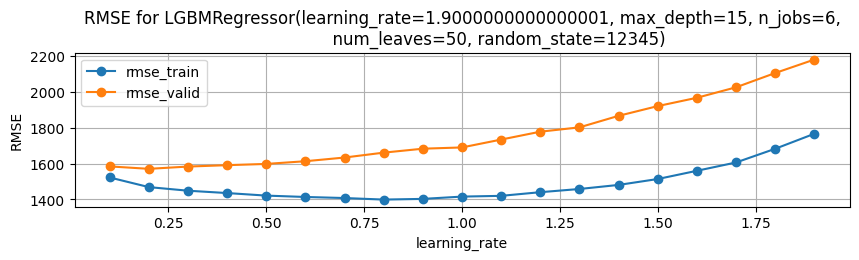

In [49]:
plot_rmse (rmse_t, rmse_v,x, model, 'learning_rate')

In [50]:
grid_space = {'n_estimators': [20,50,100],
              'max_depth' : [5,10,15,20],
              'num_leaves': [5,10,20,50],
              'learning_rate': [0.1,0.2,0.3],
              'n_jobs': [6],
              'random_state' : [12345]}

model = lgb.LGBMRegressor()
model_opt = GridSearchCV(estimator=model,
                    param_grid=grid_space,
                    cv=3,
                    scoring='neg_root_mean_squared_error')

model_opt.fit(f_train_lgb, t_train_lgb)
display(model_opt.best_params_)


{'learning_rate': 0.2,
 'max_depth': 15,
 'n_estimators': 100,
 'n_jobs': 6,
 'num_leaves': 50,
 'random_state': 12345}

определим лучшую модель lgbm

In [51]:
best_lgb = lgb.LGBMRegressor(learning_rate = 0.2,
                             max_depth = 15,
                             n_estimators = 100,
                             num_leaves = 50,
                             random_state = 12345)
best_lgb.fit(f_train_lgb, t_train_lgb)

res_t = mean_squared_error(t_train_lgb, best_lgb.predict(f_train_lgb))**0.5
res_v = mean_squared_error(t_valid_lgb, best_lgb.predict(f_valid_lgb))**0.5
    
print('learning_rate = ', round(learning_rate,1), '\tRMSE train =', round(res_t,0),
          '\tRMSE valid =', round(res_v,0))

learning_rate =  1.9 	RMSE train = 1469.0 	RMSE valid = 1571.0


## Анализ моделей

рассчитаем и сравним время обучения и предсказания для 4-х моделей

In [52]:
def mod_est (model, train_target, train_features, valid_target, valid_features):
    time0 = time.time()
    model.fit(train_features, train_target)
    time1 = time.time()
    predict = model.predict(valid_features) 
    time2 = time.time()
    rmse = int(mean_squared_error(valid_target, predict)**0.5)
    
    dt_fit = round(time1 - time0, 3)
    dt_predict = round(time2 - time1, 3)
    
    return(rmse, dt_fit, dt_predict)

In [53]:
res_lin_reg = mod_est (model_lin_reg,      t_train,     f_train,     t_valid,     f_valid)
res_tree    = mod_est (best_tree,          t_train,     f_train,     t_valid,     f_valid)
res_rf      = mod_est (best_random_forest, t_train,     f_train,     t_valid,     f_valid)

res_lgb     = mod_est (best_lgb,           t_train_lgb, f_train_lgb, t_valid_lgb, f_valid_lgb)

In [54]:
result = pd.DataFrame (data = [res_lin_reg,
                               res_tree,
                               res_rf,
                               res_lgb],
                       columns = ['rmse', 'time_fit', 'time_predict'],
                       index = ['LinearRegression', 'DecisionTree', 'RandomForest', 'LightGBM'])

result['rmse_rel'] = round(result['rmse'] / min(result['rmse']),1)
result['time_fit_rel'] = round(result['time_fit'] / min(result['time_fit']),1)
result['time_predict_rel'] = round(result['time_predict'] / min(result['time_predict']),1)
display(result)

,rmse,time_fit,time_predict,rmse_rel,time_fit_rel,time_predict_rel
LinearRegression,2419,3.487,0.127,1.5,6.6,2.8
DecisionTree,1890,2.581,0.045,1.2,4.9,1.0
RandomForest,1703,26.516,0.218,1.1,50.3,4.8
LightGBM,1570,0.527,0.111,1.0,1.0,2.5


In [55]:
res_lgb_test = mod_est (best_lgb, t_train_lgb, f_train_lgb, t_test_lgb, f_test_lgb)
print('rmse =\t\t', res_lgb_test[0])
print('time_fit =\t', res_lgb_test[1])
print('time_predict =\t', res_lgb_test[2])

rmse =		 1561
time_fit =	 0.489
time_predict =	 0.114


## Промедуточные выводы:

На валидационной выборке:
   - наименьшее rmse соответствует моделе LightGBM (1570)
   - наименьшее время обучения соответствует моделе LightGBM (0,5 сек)
   - наименьшее время предсказания соответствует моделе DecisionTree (0,05 сек)
    
Ввиду того, что модель LightGBM обладает меньшим значением rmse, чем модель DecisionTree (1505 vs 1784) и небольшим временем обучения и предсказания (0,52 и 0,12 сек соответственно), то оптимальной моделью является модель LightGBM.

На тестовой выборке, используя модель LightGBM, достигнуты следующие значения:
   - rmse = 1561
   - time_fit = 0.5
   - time_predict = 0.1

### Выводы:
    - Исходные данные содержат пропуски, аномальные значения и параметры, не влияющие на целевое значения (стоимость машины)
    - В ходе предобработки были удалены аномальные значения, заполнены пропуски, удалены параметры, не влияющие на целевое значения, удалены дубликаты. Объём данных сократился на 29.1%, 17% из них приходится на дубликаты. (с ~350 тыс строк до ~250 тыс строк)
    - Проведено обучение, подбор оптимальных параметров (с точки зрения минимизации rmse) и оценка длительности обучения и предсказания для 4-х моделей:
        - LinearRegression
        - DecisionTree
        - RandomForest
        - LightGBM
    - Модель LightGBM обладает минимальным значением rmse на тестовой выборке 1570
      значение rmse (valid) для модели RandomForest составило 1702 (+ 10% к LightGBM)
      значение rmse (valid) для модели DecisionTree составило 11890 (+ 20% к LightGBM)
      значение rmse (valid) для модели LinearRegression составило 2419 (+ 50% к LightGBM)
    - С точки зрения быстродействия (длительность обучения идлительность предсказания на выборке valid) можно выделить:
        LightGBM (0,5 и 0,1 сек соответственно)
        DecisionTree (2,6 и 0,05 сек соответственно)

Ввиду того, что модель LightGBM обладает меньшим значением rmse, чем модель DecisionTree (1570 vs 1890) и небольшим временем обучения и предсказания (0,57 и 0,15 сек соответственно), то оптимальной моделью является модель LightGBM.
    
На тестовой выборке, используя модель LightGBM, достигнуты следующие значения:
   - rmse = 1561
   - time_fit = 0.5
   - time_predict = 0.1
